- Imported libraries 
- Imported dataset 
- Created svm classifier

In [1]:
import numpy as np
import pandas as pd
from sklearn import svm
import matplotlib.pyplot as plt


# Reading in the dataset
df=pd.read_csv('SVM_Dataset2.csv')

# SVM classifier with polynomial decision boundary
svm_classifier = svm.SVC(kernel='poly',C=10, degree=2, probability=True)
# svm_classifier = svm.SVC(kernel='rbf', gamma=0.1, C=100)

c:\Users\Compuworld\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


- Used KDTree for finding the closest point
- Rewrote the optimal_point function around KDTree

In [37]:
from scipy.spatial import KDTree

# Function to find closest point to contour from the non healthy point
def closest_point(point, contour):
    tree = KDTree(contour)
    closest_index = tree.query(point)[1]
    closest_point = contour[closest_index]
    return closest_point

In [38]:
import numpy as np

def move_from_A_to_B_with_x1_displacement(A, B, delta_x1, constrs=[]):
    """
    Move from point A to point B in n-dimensional space with a desired movement in the x1 dimension.
    
    Parameters:
    - A: list or np.array, coordinates of the starting point A
    - B: list or np.array, coordinates of the target point B
    - delta_x1: float, the desired displacement in the x1 dimension
    
    Returns:
    - P: np.array, coordinates of the new point after moving delta_x1 along x1-axis
    """
    A = np.array(A)
    B = np.array(B)
    
    # Calculate direction vector from A to B
    D = B - A
    
    # Calculate the scaling factor t for the desired movement in x1
    t = delta_x1 / D[0]  # D[0] is the x1 component of the direction vector

    if len(constrs) > 0:
        for i in range(D.shape[0]): 
            D[i] = D[i] * (constrs[i])
    
    # Calculate the new point P based on t
    P = A + t * D

    print(t) 
    print(D)
    
    return P

# Example usage
A = [1, 2, 3]  # Starting point in 3D space
B = [4, 5, 6]  # Target point in 3D space
delta_x1 = 1.5  # Desired movement in x1 dimension

P = move_from_A_to_B_with_x1_displacement(A, B, delta_x1)
print("New point P with desired x1 movement:", P)

0.5
[3 3 3]
New point P with desired x1 movement: [2.5 3.5 4.5]


In [39]:
from scipy.interpolate import interp1d

def direction_func(data_pt, vector, scaler, margin): 
    modified_pt = data_pt + vector*scaler - margin
    return modified_pt

def flip_matrix(matrix):
    return matrix[::-1]

# Generates the decision boundary in the case of binary classification
def boundary_generator(xx1, xx2, model): 
    x_in = np.c_[xx1.ravel(), xx2.ravel()]
    y_pred = model.predict(x_in)
    y_pred = np.round(y_pred).reshape(xx1.shape)
    bound_data = []
    contour = plt.contour(xx1, xx2, y_pred, colors='red')
    for collection in contour.collections[:1]:
        for path in collection.get_paths():
            vertices = path.vertices
            x_coords = vertices[:, 0]
            y_coords = vertices[:, 1]
            bound_data.extend(zip(x_coords,y_coords))
    boundary_df = pd.DataFrame(data=bound_data, columns=['x1','x2'])
    return boundary_df

# Gets boundary points
def boundary_points(xx1, xx2, model): 
    boundary_df = boundary_generator(xx1=xx1, xx2=xx2, model=model)
    boundary_df = boundary_df.drop_duplicates(subset='x1')

    bound_x, bound_y = boundary_df.iloc[:, 0], boundary_df.iloc[:, 1]
    return bound_x, bound_y 

# Algorithm that determines the point that is closest to the decision boundary from a specified data point (undesired_coords) 
def optimal_point(df, model, desired_class, undesired_coords, epsilon=0.01, x1_constr=1, x2_constr=1): 

    X1=df['x1']
    X2=df['x2']
    X_train=np.array(list(zip(X1,X2)))
    y_train=df['y'].values

    model.fit(X_train, y_train)

    bound_x, bound_y = None, None
    X = X_train
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.linspace(x1_min,x1_max, 2000),np.linspace(x2_min, x2_max, 2000))

    bound_x, bound_y = boundary_points(xx1, xx2, model)

    N = 200000
    f = interp1d(bound_x, bound_y, kind='cubic')
    X_pred = np.linspace(np.min(bound_x), np.max(bound_x), N)[:, np.newaxis]
    Y_pred = f(X_pred)

    contours = np.c_[X_pred, Y_pred]
    plt.plot(X_pred, Y_pred, color='black')

    undesired_datapt = np.array([undesired_coords[0], undesired_coords[1]])
    optimal_datapt = closest_point(undesired_datapt, contour=contours)

    D = optimal_datapt - undesired_datapt
    delta_x1 = D[0]
    if desired_class == 1: 
        delta_x1 = delta_x1 * (1+epsilon)
        optimal_datapt = move_from_A_to_B_with_x1_displacement(undesired_datapt, optimal_datapt, delta_x1=delta_x1, constrs=[x1_constr, x2_constr])
        plt.scatter(undesired_datapt[0], undesired_datapt[1], c = 'r')
        plt.text(undesired_datapt[0]+0.002, undesired_datapt[1]+0.002, 'NH')
        plt.scatter(optimal_datapt[0], optimal_datapt[1], c = 'b')
        plt.text(optimal_datapt[0]+0.002, optimal_datapt[1]+0.002, 'H')
        plt.plot([undesired_datapt[0], optimal_datapt[0]], [undesired_datapt[1],optimal_datapt[1]], linestyle='--')
        return optimal_datapt 
    elif desired_class == -1: 
        optimal_datapt = move_from_A_to_B_with_x1_displacement(undesired_datapt, optimal_datapt, delta_x1=delta_x1, constrs=[x1_constr, x2_constr])
        plt.scatter(undesired_datapt[0], undesired_datapt[1], c = 'r')
        plt.text(undesired_datapt[0]+0.002, undesired_datapt[1]+0.002, 'NH')
        plt.scatter(optimal_datapt[0], optimal_datapt[1], c = 'r')
        plt.text(optimal_datapt[0]+0.002, optimal_datapt[1]+0.002, 'NH')
        plt.plot([undesired_datapt[0], optimal_datapt[0]], [undesired_datapt[1],optimal_datapt[1]], linestyle='--')
        return optimal_datapt

1.07
[-0.27054087 -4.52735398]


array([10.71052127, 10.15573124])

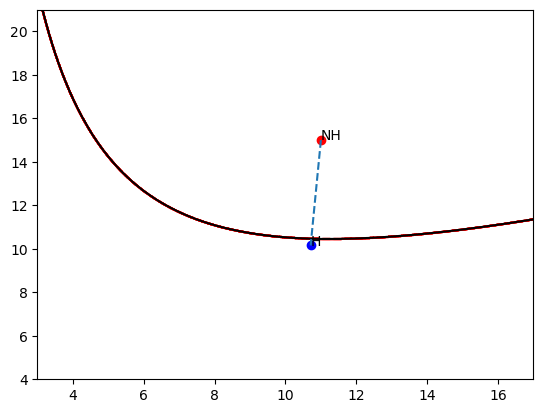

In [46]:
optimal_projection1 = optimal_point(df, svm_classifier, desired_class=1, undesired_coords=(11,15), epsilon=0.07)
optimal_projection1

     x1  x2
0   7.0  20
1   8.0  12
2   9.0  19
3  10.0  17
4  11.0  15
5  13.0  14
6  14.0  12
7  15.0  14
8  15.0  17
9  16.0  16
1.05
[-3.57288938 -0.6407448 ]
1.05
[-0.4127413  -0.69482652]
1.05
[-5.2099653 -1.2938909]
1.05
[-5.21218395 -2.30546576]
1.05
[-0.27054087 -4.52735398]
1.05
[ 0.51421018 -3.36582022]
1.05
[ 0.21448665 -1.2552767 ]
1.05
[ 0.72695907 -2.94918771]
1.05
[ 1.47636923 -5.77057428]
1.05
[ 0.9807346  -4.64298964]


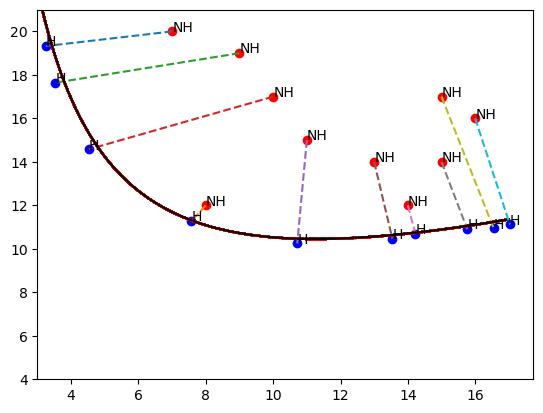

In [54]:
# Data frame consisting of all "non-healthy" data points or points where the classification is -1
undesired_df = df.loc[df['y'] == -1]

undesired_df = undesired_df.drop(columns=['y'])
print(undesired_df)
optimal_datapts1 = pd.DataFrame(data=[], columns=('x1', 'x2'))

# Iterates over each of the rows of the undesired dataframe and finds the optimal point
for r in range(undesired_df.shape[0]): 
    
    # Undesired data point
    data_pt = undesired_df.iloc[r]  
    optimal_pt = optimal_point(df, svm_classifier, desired_class=1, undesired_coords=(data_pt.iloc[0], data_pt.iloc[1]), epsilon=0.05)
    optimal_datapts1.loc[len(optimal_datapts1)] = optimal_pt

In [55]:
optimal_datapts1

,x1,x2
0,3.248466,19.327218
1,7.566622,11.270432
2,3.529536,17.641415
3,4.527207,14.579261
4,10.715932,10.246278
5,13.539921,10.465889
6,14.225211,10.681959
7,15.763307,10.903353
8,16.550188,10.940897
9,17.029771,11.124861


- The black line was generated from a set of points where the probability from the classifier matched 0.5 exactly or was sufficiently close to 0.5 (50%) 
- The red line was generated using the boundary function that we have defined above

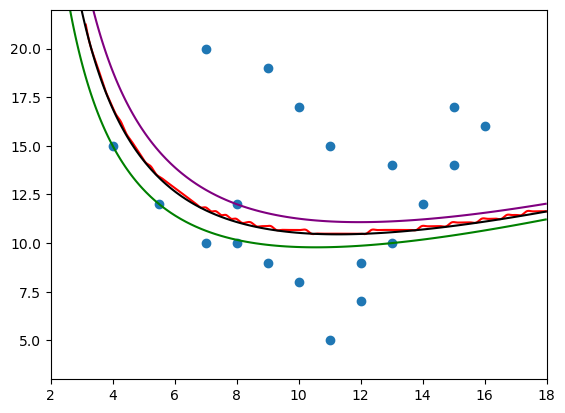

In [56]:
X1=df['x1']
X2=df['x2']
X_train=np.array(list(zip(X1,X2)))
y_train=df['y'].values
X=X_train

svm_classifier.fit(X_train, y_train)

X = X_train
x1_min, x1_max = X[:, 0].min() - 2, X[:, 0].max() + 2
x2_min, x2_max = X[:, 1].min() - 2, X[:, 1].max() + 2

xx1, xx2 = np.meshgrid(np.linspace(x1_min,x1_max, 100),np.linspace(x2_min, x2_max, 100))
Z = svm_classifier.decision_function(np.array([xx1.ravel(), xx2.ravel()]).T).reshape(xx1.shape)
x_in = np.c_[xx1.ravel(), xx2.ravel()]
y_pred = svm_classifier.predict(x_in)
y_pred = np.round(y_pred).reshape(xx1.shape)

bound_data = []
contour = plt.contour(xx1, xx2, y_pred, colors='black')
for collection in contour.collections[:1]:
    for path in collection.get_paths():
        vertices = path.vertices
        x_coords = vertices[:, 0]
        y_coords = vertices[:, 1]
        bound_data.extend(zip(x_coords,y_coords))
for collection in contour.collections:
    collection.set_visible(False)
boundary_df = pd.DataFrame(data=bound_data, columns=['x1','x2'])
N=200000
boundary_df = boundary_df.drop_duplicates(subset='x1')
bound_x, bound_y = boundary_df.iloc[:, 0], boundary_df.iloc[:, 1]

f = interp1d(bound_x, bound_y, kind='cubic')
X_pred = np.linspace(np.min(bound_x), np.max(bound_x), N)[:, np.newaxis]
Y_pred = f(X_pred)
plt.plot(X_pred, Y_pred, c='r')
plt.contour(xx1, xx2, Z, levels=[-1, 0, 1], colors=['purple','black','green'])
plt.scatter(X[:, 0], X[:, 1])
plt.show()

1.0
[-0.71457788 -0.12814896]


array([ 6.28542212, 19.87185104])

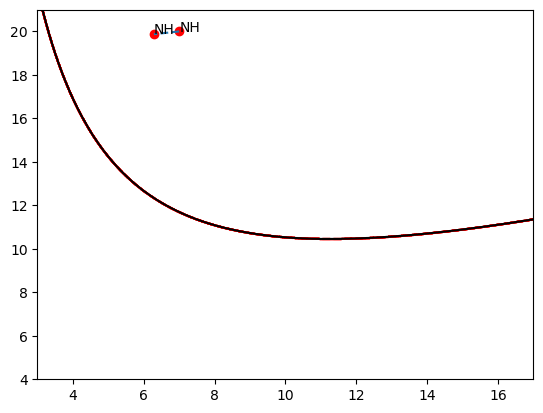

In [57]:
optimal_projection = optimal_point(df, svm_classifier, desired_class=-1, undesired_coords=(7,20), x1_constr=0.2, x2_constr=0.2)
optimal_projection

1.0
[-1.78644469 -0.3203724 ]


array([ 5.21355531, 19.6796276 ])

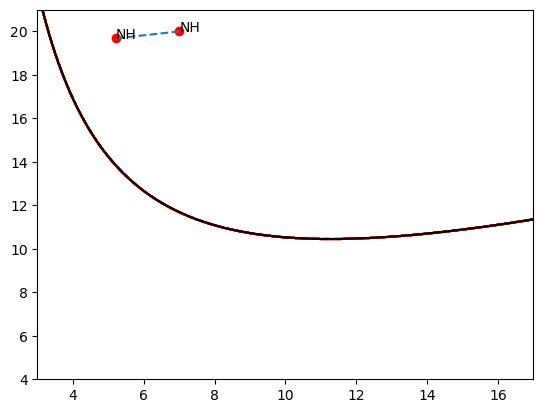

In [58]:
optimal_projection = optimal_point(df, svm_classifier, desired_class=-1, undesired_coords=(7,20), x1_constr=0.5, x2_constr=0.5)
optimal_projection

1.0
[-2.8583115  -0.51259584]


array([ 4.1416885 , 19.48740416])

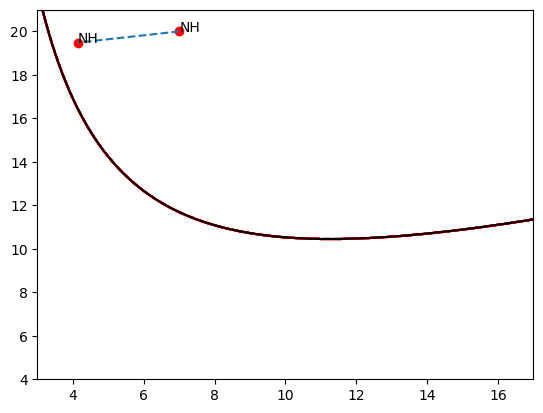

In [59]:
optimal_projection = optimal_point(df, svm_classifier, desired_class=-1, undesired_coords=(7,20), x1_constr=0.8, x2_constr=0.8)
optimal_projection

1.0
[-3.53716049 -0.63433735]


array([ 3.46283951, 19.36566265])

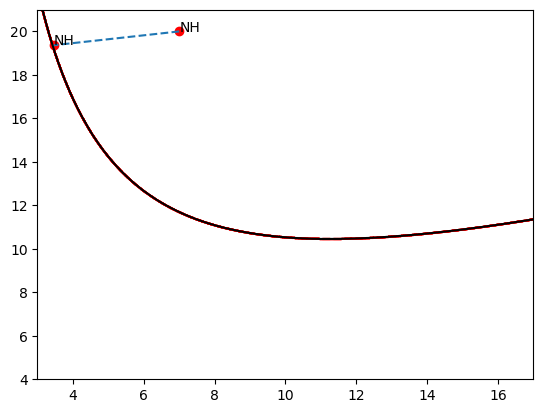

In [60]:
optimal_projection = optimal_point(df, svm_classifier, desired_class=-1, undesired_coords=(7,20), x1_constr=0.99, x2_constr=0.99)
optimal_projection

1.0
[-1.30304599 -0.57636644]


array([ 8.69695401, 16.42363356])

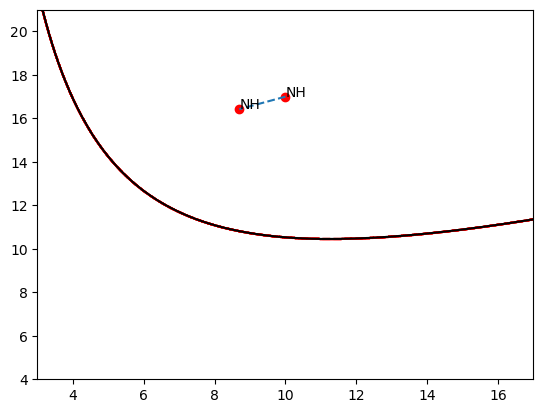

In [63]:
optimal_projection = optimal_point(df, svm_classifier, desired_class=-1, undesired_coords=(10,17), x1_constr=0.25, x2_constr=0.25)
optimal_projection

In [69]:
import random 
random.seed(0)
synthetic_df = pd.read_csv('SVM_Dataset2.csv')
cat_col = [] 
for i in range(synthetic_df.shape[0]): 
    random_num = random.randint(0,1) 
    cat_col.append(random_num) 

cat_col 

[1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1]

In [70]:
synthetic_df.insert(2, "Sex", cat_col, True) 
print(synthetic_df)

      x1  x2  Age  y
0    7.0  20    1 -1
1    8.0  12    1 -1
2    9.0  19    0 -1
3   10.0  17    1 -1
4   11.0  15    1 -1
5   13.0  14    1 -1
6   14.0  12    1 -1
7   15.0  14    1 -1
8   15.0  17    1 -1
9   16.0  16    0 -1
10   4.0  15    0  1
11   5.5  12    1  1
12   7.0  10    0  1
13   8.0  10    0  1
14   9.0   9    1  1
15  10.0   8    0  1
16  11.0   5    1  1
17  12.0   7    0  1
18  12.0   9    0  1
19  13.0  10    1  1


In [71]:
synthetic_df.to_csv("synthetic_dataset.csv", index=False)

Working with Categorical Features



For having both categorical and numerical features:

	- If we have C categorical features that can not be changes and N features in total, the search space would be N-C


In [75]:
# Algorithm that determines the point that is closest to the decision boundary from a specified data point (undesired_coords) 
def optimal_point(df, model, desired_class, undesired_coords, epsilon=0.01, x1_constr=1, x2_constr=1): 

    list_feats = np.zeros((20,1))

    # Out of a collection of N features with C categorical features, we remove C categorical features such that the space only consists of N-C variables
    for col in df.columns:
        
        col_feat = df[col] 
    
        count0   = len(col_feat[col_feat==0])
        count1   = len(col_feat[col_feat==1])

        if col != 'y' and not (len(col_feat) == count0 + count1): 
            np_col = col_feat.to_numpy().reshape(-1,1)
            list_feats = np.append(list_feats, np_col, axis=1)

    list_feats = np.delete(list_feats, 0, axis=1)

    X_train=list_feats
    y_train=df['y'].values

    model.fit(X_train, y_train)

    bound_x, bound_y = None, None
    X = X_train
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.linspace(x1_min,x1_max, 2000),np.linspace(x2_min, x2_max, 2000))

    bound_x, bound_y = boundary_points(xx1, xx2, model)

    N = 200000
    f = interp1d(bound_x, bound_y, kind='cubic')
    X_pred = np.linspace(np.min(bound_x), np.max(bound_x), N)[:, np.newaxis]
    Y_pred = f(X_pred)

    contours = np.c_[X_pred, Y_pred]
    plt.plot(X_pred, Y_pred, color='black')

    undesired_datapt = np.array([undesired_coords[0], undesired_coords[1]])
    optimal_datapt = closest_point(undesired_datapt, contour=contours)

    D = optimal_datapt - undesired_datapt
    delta_x1 = D[0]
    if desired_class == 1: 
        delta_x1 = delta_x1 * (1+epsilon)
        optimal_datapt = move_from_A_to_B_with_x1_displacement(undesired_datapt, optimal_datapt, delta_x1=delta_x1, constrs=[x1_constr, x2_constr])
        plt.scatter(undesired_datapt[0], undesired_datapt[1], c = 'r')
        plt.text(undesired_datapt[0]+0.002, undesired_datapt[1]+0.002, 'NH')
        plt.scatter(optimal_datapt[0], optimal_datapt[1], c = 'b')
        plt.text(optimal_datapt[0]+0.002, optimal_datapt[1]+0.002, 'H')
        plt.plot([undesired_datapt[0], optimal_datapt[0]], [undesired_datapt[1],optimal_datapt[1]], linestyle='--')
        return optimal_datapt 
    elif desired_class == -1: 
        optimal_datapt = move_from_A_to_B_with_x1_displacement(undesired_datapt, optimal_datapt, delta_x1=delta_x1, constrs=[x1_constr, x2_constr])
        plt.scatter(undesired_datapt[0], undesired_datapt[1], c = 'r')
        plt.text(undesired_datapt[0]+0.002, undesired_datapt[1]+0.002, 'NH')
        plt.scatter(optimal_datapt[0], optimal_datapt[1], c = 'r')
        plt.text(optimal_datapt[0]+0.002, optimal_datapt[1]+0.002, 'NH')
        plt.plot([undesired_datapt[0], optimal_datapt[0]], [undesired_datapt[1],optimal_datapt[1]], linestyle='--')
        return optimal_datapt

# Using the Synthetic Dataset 

- Below, we use the synthetic dataset constructed from three features (two from the original SVM dataset and one categorical variable for the sex)

1.05
[-0.27054087 -4.52735398]


array([10.71593209, 10.24627832])

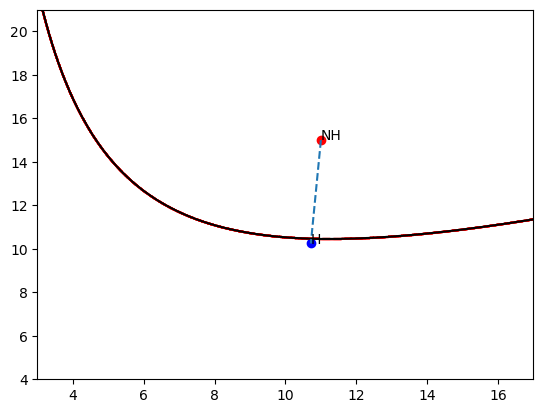

In [76]:
optimal_projection1 = optimal_point(synthetic_df, svm_classifier, desired_class=1, undesired_coords=(11,15), epsilon=0.05)
optimal_projection1